In [ ]:
!wget -x --load-cookies kaggle_cookies.txt "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/14774/875431/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1663427683&Signature=B5Hgh5CAuxmy4FI3pW5E%2BawhcwIVbQxI2n22FU00m5BFghP0PTnB3GaTs4t3JbBE9sgouaMAFLqKMaRnoKUdIkEd2WTFPc8Lr5Dvz62gi%2Bw5mQZwY4zcKDkbe0JU4jJOgVcxvDNkdniYVnZo%2Fg5mxc0lxFfuGtSHA985IR0mhSmzT1PUZj0aJaF%2BRSNIae1QYcozVhyt0lqd8sk7frywNK%2F2UtW3k%2BC%2FlU6OItp1PG%2Bp7pyZiz%2FVZ99TT8V%2Bg3p5geneiDZRPCKUYzp6QQ38RvMZbYGHkpDJd9rgYUWEm%2FmyKp6pXdFFufY7sp7ocBCiy0CCVqySsnZlE3TkKdtQbA%3D%3D&response-content-disposition=attachment%3B+filename%3Daptos2019-blindness-detection.zip" -O data.zip

In [ ]:
!unzip data.zip

Train Size = 3662
Test Size = 1928


Text(0.5, 0, 'Diagnosis')

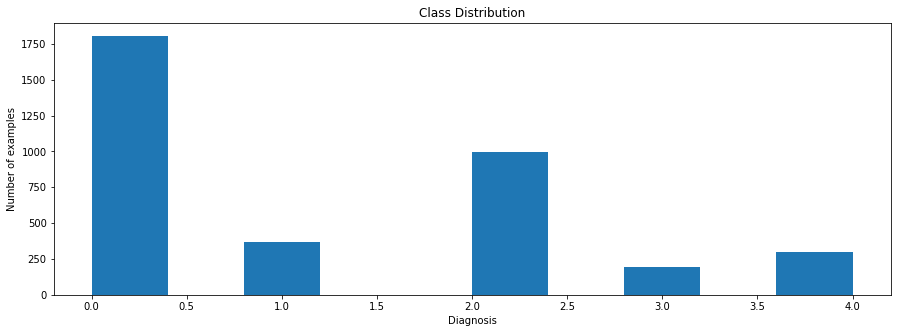

In [4]:
import numpy as np
import pandas as pd

import torch
import torchvision
from tensorflow.keras.optimizers import Adam
from torchvision import transforms, datasets
from torch.utils.data import Dataset

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm

import random
import time
import sys
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')
print('Train Size = {}'.format(len(train_csv)))
print('Test Size = {}'.format(len(test_csv)))

##### CLASS DISTRIBUTION
# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train_csv['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

In [5]:
def append_ext(fn):
    return fn+".png"
train_csv["id_code"]=train_csv["id_code"].apply(append_ext)
test_csv["id_code"]=test_csv["id_code"].apply(append_ext)

In [6]:
cleanup_nums = {"diagnosis":     { 4: "Proliferative DR", 3: "Severe" , 2:"Moderate", 1:"Mild", 0:"No DR" }}
train_csv = train_csv.replace(cleanup_nums)

In [7]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7.png,Moderate
1,001639a390f0.png,Proliferative DR
2,0024cdab0c1e.png,Mild
3,002c21358ce6.png,No DR
4,005b95c28852.png,No DR


## Preprocessing

In [8]:
### image preprocessing function
def prepare_image(path, sigmaX = 10, do_random_crop = False):
    image_size = 256
    # import image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    #image = torch.tensor(image)
    #image = image.permute(1, 0, 2)
    return image


### automatic crop of black areas
def crop_black(img, tol = 7):
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img
        
        
### circular crop around center
def circle_crop(img, sigmaX = 10):   
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img 


### random crop
def random_crop(img, size = (0.9, 1)):

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

In [9]:
!mkdir train_images_processed
!mkdir test_images_processed

In [ ]:
import glob
import os
dir_name = 'train_images/'
# Get list of all files in a given directory sorted by name
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )
# Iterate over sorted list of files and print the file paths 
# one by one.
for file_path in list_of_files:
    print(file_path[13::])
    prepared = prepare_image(file_path)
    cv2.imwrite(f"train_images_processed/{file_path[13::]}", prepared)

In [ ]:
import glob
import os
dir_name = 'test_images/'
# Get list of all files in a given directory sorted by name
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )
# Iterate over sorted list of files and print the file paths 
# one by one.
for file_path in list_of_files:
    print(file_path[13::])
    prepared = prepare_image(file_path)
    cv2.imwrite(f"test_images_processed/{file_path[13::]}", prepared)

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data generator
train_gen = ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        rotation_range=20 ,      # Degree range for random rotations
        zoom_range=0.1,
        validation_split=0.20)

test_gen = ImageDataGenerator(rescale=1 / 255.0)

In [15]:
# train_folder = "./train_images/"
train_folder = "./train_images_processed/"
test_folder = "./test_images/"

## My Model


In [ ]:
train_data = train_gen.flow_from_dataframe(dataframe = train_csv, 
directory = train_folder, x_col = "id_code", 
y_col = "diagnosis", seed = 42,
batch_size = 20, shuffle = True, color_mode='grayscale', 
class_mode="categorical",target_size = (256, 256), subset='training')

valid_data = train_gen.flow_from_dataframe(dataframe = train_csv, 
directory = train_folder, x_col = "id_code", 
y_col = "diagnosis",
batch_size = 20, shuffle = True, color_mode='grayscale', 
class_mode="categorical",target_size = (256,256), subset='validation')  

test_data = test_gen.flow_from_dataframe(dataframe = test_csv, 
directory = test_folder, x_col = "id_code", 
batch_size = 1, shuffle = False, color_mode='grayscale', 
class_mode=None,target_size = (256,256))

In [ ]:
num_classes = 5

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [ ]:
model.compile(loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy'])

model.summary()

In [ ]:
train_csv.groupby('diagnosis').nunique()

In [ ]:
from sklearn.utils import compute_class_weight
train_classes = train_data.classes
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

In [ ]:
model.fit_generator(train_data,
                    validation_data = train_data,
                    steps_per_epoch = train_data.n//train_data.batch_size,
                    validation_steps = valid_data.n//valid_data.batch_size,
                    class_weight= class_weights,
                    epochs=10)

In [ ]:
predict=model.predict_generator(test_data, steps = len(test_data.filenames))

In [ ]:
y_classes = predict.argmax(axis=-1)
x = np.array(y_classes)
print(np.unique(x))

## DenseNet

In [28]:
train_data = train_gen.flow_from_dataframe(dataframe = train_csv, 
directory = train_folder, x_col = "id_code", 
y_col = "diagnosis", seed = 42,
batch_size = 20, shuffle = True, color_mode='rgb', 
class_mode="categorical",target_size = (256, 256), subset='training')

valid_data = train_gen.flow_from_dataframe(dataframe = train_csv, 
directory = train_folder, x_col = "id_code", 
y_col = "diagnosis",
batch_size = 20, shuffle = True, color_mode='rgb', 
class_mode="categorical",target_size = (256,256), subset='validation')

test_data = test_gen.flow_from_dataframe(dataframe = test_csv, 
directory = test_folder, x_col = "id_code", 
batch_size = 1, shuffle = False, color_mode='rgb', 
class_mode=None,target_size = (256,256))

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [34]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from keras import layers

effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(256,256,3)
)

model = Sequential()
model.add(effnet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy'],
)

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 8,092,229
Trainable params: 8,008,581
Non-trainable params: 83,648
_______________________________________

In [36]:
from sklearn.utils import compute_class_weight
train_classes = train_data.classes
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 2.0,
 1: 0.7532133676092545,
 2: 0.3991825613079019,
 3: 2.483050847457627,
 4: 3.7806451612903227}

In [38]:
history = model.fit(
    train_data,
    steps_per_epoch= train_data.n//train_data.batch_size,
    epochs=5,
    validation_data= valid_data,
    class_weight=class_weights    
)   

Epoch 1/5
146/146 [==============================] - 73s 496ms/step - loss: 0.2388 - accuracy: 0.8089 - val_loss: 0.2074 - val_accuracy: 0.7541
Epoch 2/5
146/146 [==============================] - 76s 517ms/step - loss: 0.2276 - accuracy: 0.8072 - val_loss: 0.2447 - val_accuracy: 0.7555
Epoch 3/5
146/146 [==============================] - 71s 488ms/step - loss: 0.2206 - accuracy: 0.8220 - val_loss: 0.2117 - val_accuracy: 0.7623
Epoch 4/5
146/146 [==============================] - 71s 482ms/step - loss: 0.2003 - accuracy: 0.8378 - val_loss: 0.2552 - val_accuracy: 0.7254
Epoch 5/5
146/146 [==============================] - 72s 491ms/step - loss: 0.1827 - accuracy: 0.8447 - val_loss: 0.2029 - val_accuracy: 0.7978


In [44]:
model.save("DR_Dense_model")

In [45]:
!zip -r "DR_dense_model.zip" "DR_Dense_model"

  adding: DR_Dense_model/ (stored 0%)
  adding: DR_Dense_model/keras_metadata.pb (deflated 96%)
  adding: DR_Dense_model/assets/ (stored 0%)
  adding: DR_Dense_model/saved_model.pb (deflated 92%)
  adding: DR_Dense_model/variables/ (stored 0%)
  adding: DR_Dense_model/variables/variables.index (deflated 81%)
  adding: DR_Dense_model/variables/variables.data-00000-of-00001 (deflated 11%)


In [26]:
predict=model.predict_generator(test_data, steps = len(test_data.filenames))

In [ ]:
y_classes = predict.argmax(axis=-1)
x = np.array(y_classes)
print(np.unique(x))

## submission

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
i=0
while i < len(y_classes):
  submission["diagnosis"].loc[i] = y_classes[i]
  i= i+1

In [ ]:
submission["diagnosis"]

In [ ]:
submission.to_csv('final.csv',index=False)

## Testing

In [22]:
train_data.class_indices

{'Mild': 0, 'Moderate': 1, 'No DR': 2, 'Proliferative DR': 3, 'Severe': 4}

{0: 'Mild', 1: 'Moderate', 2: 'No DR', 3: 'Proliferative DR', 4: 'Severe'}
Proliferative DR


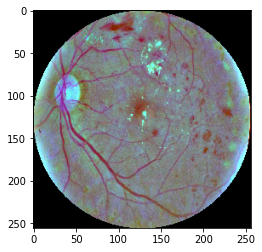

In [43]:
# Testing the model
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
import numpy as np

# This reshape corresponds to 1 image of 28x28 pixels with one color channel
image = image_utils.load_img("train_images_processed/fb696a8e055a.png", color_mode="rgb", target_size=(256,256))
plt.imshow(image, cmap='gray')
image = image_utils.img_to_array(image)
image = image.reshape(1,256,256,3)

prediction = model.predict(image)


labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
results = ["Mild","Moderate","No DR","Proliferative DR","Severe"]
print(results[np.argmax(prediction)])

In [39]:
import glob
import os
dir_name = 'test_images_processed/'
# Get list of all files in a given directory sorted by name
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )
# Iterate over sorted list of files and print the file paths 
# one by one.
for file_path in list_of_files:
    #print(file_path)
    # This reshape corresponds to 1 image of 28x28 pixels with one color channel
    image = image_utils.load_img(file_path, color_mode="rgb", target_size=(256,256))
    image = image_utils.img_to_array(image)
    image = image.reshape(1, 256,256,3)

    prediction = model.predict(image)
    print(np.argmax(prediction))

1
1
1
1
1
1
1
1
2
2
1
4
4
1
2
0
2
1
4
4
1
1
1
1
4
2
2
2
0
4
0
1
1
1
1
1
0
2
3
1
1
4
2
1
1
1
1
1
0
2
1
1
1
2
1
4
1
0
0
4
4
4
1
0
1
4
4
1
4
4
1
4
4
1
4
1
4
3
4
4
1
4
0
1
1
1
4
1
1
4
1
4
3
4
1
2
4
1
1
1
1
4
4
1
1
4
1
1
4
4
1
2
1
1
2
4
4
1
0
4
2
1
1
1
4
4
4
2
4
2
4
1
4
0
1
2
1
4
1
0
0
4
1
1
2
1
0
0
1
1
2
4
1
1
1
1
4
1
1
4
0
1
1
0
2
4
1
2
1
4
4
1
1
1
4
0
4
1
1
1
1
1
4
4
1
4
4
2
4
4
1
1
1
4
4
2
4
1
1
1
1
4
4
1
4
1
1
2
0
4
0
4
1
1
1
0
4
4
4
4
3


KeyboardInterrupt: ignored